### Import statements

Since Great Expectations is listed in the requirements.txt file, Deepnote will install it when the hardware starts. Read more about package installation here.

In [34]:
# CS 6603 Final Group project: Mark P Abbott - mabbott7, Michael Countouris - mcountouris3, Soon Ryu - sryu71
# 기본 데이터 처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing


In [35]:
# STEP 1: Dataset Analysis
# Run this after your import cell

# Load the dataset (adjust path if needed)
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', encoding='utf-8-sig', on_bad_lines='skip')

print("="*60)
print("STEP 1: DATASET ANALYSIS RESULTS")
print("="*60)

# Answer to Question 1: Dataset selected
print("\n1. DATASET SELECTED: Employee Attrition")
print("   Name: WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("   Link: https://www.kaggle.com/datasets/patelprashant/employee-attrition")

# Answer to Question 2: Regulated domain
print("\n2. REGULATED DOMAIN:")
print("   Employment (HR/Human Resources)")

# Answer to Question 3: Number of observations
print(f"\n3. NUMBER OF OBSERVATIONS:")
print(f"   {len(df)} observations")

# Answer to Question 4: Number of variables
print(f"\n4. NUMBER OF VARIABLES:")
print(f"   {len(df.columns)} variables")

# Answer to Question 5: Dependent/outcome variables
print(f"\n5. DEPENDENT/OUTCOME VARIABLES:")
print("   - Attrition (Primary): Employee turnover (Yes/No)")
print(f"     Values: {list(df['Attrition'].unique())}")

attrition_counts = df['Attrition'].value_counts()
total = len(df)
no_pct = (attrition_counts['No'] / total) * 100
yes_pct = (attrition_counts['Yes'] / total) * 100
print(f"     Distribution: No: {attrition_counts['No']} ({no_pct:.1f}%), Yes: {attrition_counts['Yes']} ({yes_pct:.1f}%)")

print()
print("   - PerformanceRating (Secondary): Performance score")
print(f"     Values: {list(df['PerformanceRating'].unique())}")

perf_counts = df['PerformanceRating'].value_counts()
rating3_pct = (perf_counts[3] / total) * 100
rating4_pct = (perf_counts[4] / total) * 100
print(f"     Distribution: Rating 3: {perf_counts[3]} ({rating3_pct:.1f}%), Rating 4: {perf_counts[4]} ({rating4_pct:.1f}%)")

# Answer to Question 6: Protected class variables
print(f"\n6. PROTECTED CLASS VARIABLES:")
print(f"   Total: 3 protected class variables")
print()
print("   - Age (Continuous)")
print(f"     Range: {df['Age'].min()} to {df['Age'].max()} years")
print()
print("   - Gender (Categorical)")
print(f"     Values: {list(df['Gender'].unique())}")

gender_counts = df['Gender'].value_counts()
male_pct = (gender_counts['Male'] / total) * 100
female_pct = (gender_counts['Female'] / total) * 100
print(f"     Distribution: Male: {gender_counts['Male']} ({male_pct:.1f}%), Female: {gender_counts['Female']} ({female_pct:.1f}%)")

print()
print("   - MaritalStatus (Categorical)")
print(f"     Values: {list(df['MaritalStatus'].unique())}")

marital_counts = df['MaritalStatus'].value_counts()
married_pct = (marital_counts['Married'] / total) * 100
single_pct = (marital_counts['Single'] / total) * 100
divorced_pct = (marital_counts['Divorced'] / total) * 100
print(f"     Distribution: Married: {marital_counts['Married']} ({married_pct:.1f}%), Single: {marital_counts['Single']} ({single_pct:.1f}%), Divorced: {marital_counts['Divorced']} ({divorced_pct:.1f}%)")

# Answer to Question 7: Legal precedence/law
print(f"\n7. LEGAL PRECEDENCE FOR EACH PROTECTED CLASS:")
print("   - Age: Age Discrimination in Employment Act (ADEA)")
print("         Protects workers 40+ years old")
print()
print("   - Gender: Title VII of Civil Rights Act of 1964")
print("           Prohibits employment discrimination based on sex")
print()
print("   - MaritalStatus: Fair Employment and Housing Act")
print("                  Prohibits discrimination based on marital status")

# Requirements check
print(f"\n8. PROJECT REQUIREMENTS CHECK:")
print(f"   ✓ At least 500 observations? YES ({len(df)} observations)")
print(f"   ✓ At least 2 protected classes? YES (3 classes)")
print(f"   ✓ At least 2 dependent variables? YES (2 variables)")
print(f"   ✓ Related to regulated domain? YES (Employment)")

print(f"\n9. DATA QUALITY CHECK:")
missing_count = df.isnull().sum().sum()
if missing_count == 0:
    print("   ✓ No missing values found!")
else:
    print(f"   ⚠ {missing_count} missing values found")

STEP 1: DATASET ANALYSIS RESULTS

1. DATASET SELECTED: Employee Attrition
   Name: WA_Fn-UseC_-HR-Employee-Attrition.csv
   Link: https://www.kaggle.com/datasets/patelprashant/employee-attrition

2. REGULATED DOMAIN:
   Employment (HR/Human Resources)

3. NUMBER OF OBSERVATIONS:
   1470 observations

4. NUMBER OF VARIABLES:
   35 variables

5. DEPENDENT/OUTCOME VARIABLES:
   - Attrition (Primary): Employee turnover (Yes/No)
     Values: ['Yes', 'No']
     Distribution: No: 1233 (83.9%), Yes: 237 (16.1%)

   - PerformanceRating (Secondary): Performance score
     Values: [np.int64(3), np.int64(4)]
     Distribution: Rating 3: 1244 (84.6%), Rating 4: 226 (15.4%)

6. PROTECTED CLASS VARIABLES:
   Total: 3 protected class variables

   - Age (Continuous)
     Range: 18 to 60 years

   - Gender (Categorical)
     Values: ['Female', 'Male']
     Distribution: Male: 882 (60.0%), Female: 588 (40.0%)

   - MaritalStatus (Categorical)
     Values: ['Single', 'Married', 'Divorced']
     Distribut

In [36]:
# Install AIF360 confirmation
try:
    import aif360
    print("✅ AIF360 successfully installed!")
    print("Version:", aif360.__version__)
except ImportError as e:
    print("❌ AIF360 installation failed:", e)

✅ AIF360 successfully installed!
Version: 0.6.1


In [37]:
# Step 2: Dataset exploration

# 2.1 Protected class subgroups
print("=== STEP 2.1: Protected Class Subgroups ===")
print("Age groups:", df['Age'].unique()[:10], "... (continuous)")
print("Gender:", df['Gender'].unique())
print("MaritalStatus:", df['MaritalStatus'].unique())

# 2.2 Discretize subgroups 
print("\n=== STEP 2.2: Discretize Subgroups ===")
# Convert to numerical values
df['Gender_num'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['MaritalStatus_num'] = df['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Divorced': 2})
df['Attrition_num'] = df['Attrition'].map({'No': 0, 'Yes': 1})
df['PerformanceRating_num'] = df['PerformanceRating'].map({3: 0, 4: 1})

print("Gender mapping: Male=0, Female=1")
print("MaritalStatus mapping: Single=0, Married=1, Divorced=2") 
print("Attrition mapping: No=0, Yes=1")
print("PerformanceRating mapping: 3=0, 4=1")

# 2.3 Select two protected classes
print("\n=== STEP 2.3: Selected Protected Classes ===")
print("1. Gender")
print("2. MaritalStatus")

# 2.4 Frequency tables
print("\n=== STEP 2.4: Frequency Tables ===")
print("Gender vs Attrition:")
print(pd.crosstab(df['Gender'], df['Attrition']))

print("\nMaritalStatus vs Attrition:")
print(pd.crosstab(df['MaritalStatus'], df['Attrition']))

print("\nGender vs PerformanceRating:")
print(pd.crosstab(df['Gender'], df['PerformanceRating']))

print("\nMaritalStatus vs PerformanceRating:")
print(pd.crosstab(df['MaritalStatus'], df['PerformanceRating']))

=== STEP 2.1: Protected Class Subgroups ===
Age groups: [41 49 37 33 27 32 59 30 38 36] ... (continuous)
Gender: ['Female' 'Male']
MaritalStatus: ['Single' 'Married' 'Divorced']

=== STEP 2.2: Discretize Subgroups ===
Gender mapping: Male=0, Female=1
MaritalStatus mapping: Single=0, Married=1, Divorced=2
Attrition mapping: No=0, Yes=1
PerformanceRating mapping: 3=0, 4=1

=== STEP 2.3: Selected Protected Classes ===
1. Gender
2. MaritalStatus

=== STEP 2.4: Frequency Tables ===
Gender vs Attrition:
Attrition   No  Yes
Gender             
Female     501   87
Male       732  150

MaritalStatus vs Attrition:
Attrition       No  Yes
MaritalStatus          
Divorced       294   33
Married        589   84
Single         350  120

Gender vs PerformanceRating:
PerformanceRating    3    4
Gender                     
Female             494   94
Male               750  132

MaritalStatus vs PerformanceRating:
PerformanceRating    3    4
MaritalStatus              
Divorced           279   48
Marri

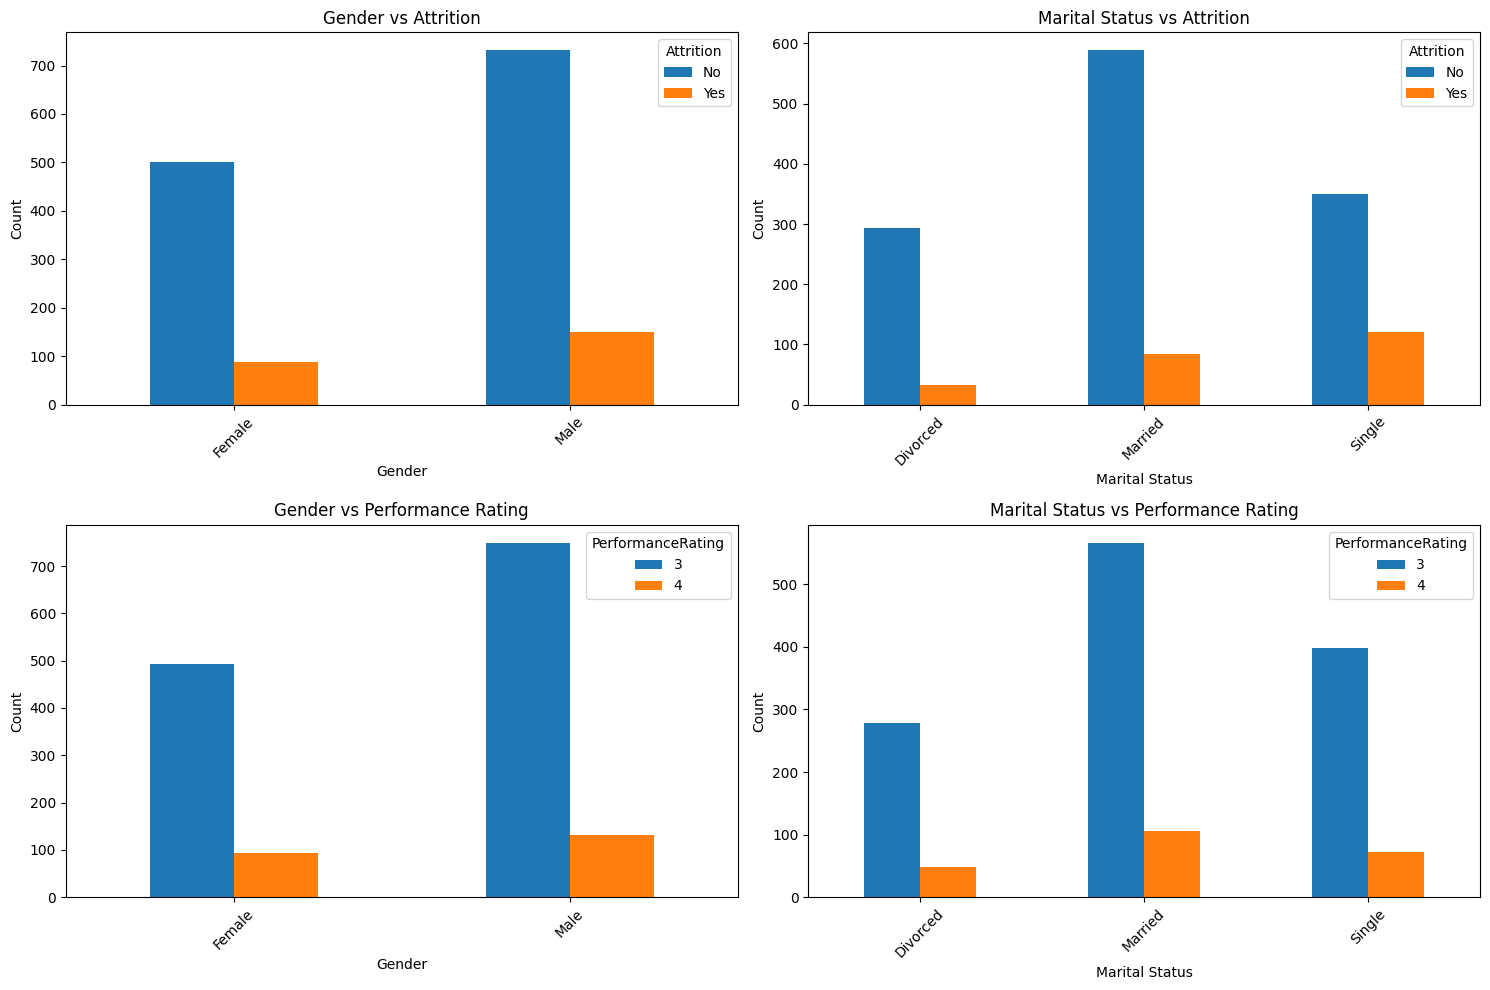

In [38]:
# Step 2.5: Bar charts
plt.figure(figsize=(15, 10))

# Chart 1: Gender vs Attrition
plt.subplot(2, 2, 1)
gender_attrition = pd.crosstab(df['Gender'], df['Attrition'])
gender_attrition.plot(kind='bar', ax=plt.gca())
plt.title('Gender vs Attrition')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Chart 2: MaritalStatus vs Attrition  
plt.subplot(2, 2, 2)
marital_attrition = pd.crosstab(df['MaritalStatus'], df['Attrition'])
marital_attrition.plot(kind='bar', ax=plt.gca())
plt.title('Marital Status vs Attrition')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Chart 3: Gender vs PerformanceRating
plt.subplot(2, 2, 3)
gender_performance = pd.crosstab(df['Gender'], df['PerformanceRating'])
gender_performance.plot(kind='bar', ax=plt.gca())
plt.title('Gender vs Performance Rating')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Chart 4: MaritalStatus vs PerformanceRating
plt.subplot(2, 2, 4)
marital_performance = pd.crosstab(df['MaritalStatus'], df['PerformanceRating'])
marital_performance.plot(kind='bar', ax=plt.gca())
plt.title('Marital Status vs Performance Rating')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('2_5_protected_class_charts.png')
plt.show()
plt.close()

In [39]:
""" Encoding all categorical features for training. Preprocessing prior to creating model required. Useless features include:
 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'. Using OHE for 'BuisnessTravel', 'Department', 'EducationField', 'JobRole', Label encoding for 'OverTime'
 Performing preprocessing prior to step 3 as all transformations do not impact protected class calculations."""

df['OverTime'] = (df['OverTime'] == 'No').astype(int)  # 1 = No, 0 = Yes following binning convention

drop_cols = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'] # Features that do not add info

categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'JobRole'] # Features for OHE

numerical_features = ['DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

# variable features incude the features that will be binned in step 3 while not strictly numerical. After binning, the original features will be dropped.
variable_features = ['Age', 'Gender', 'MaritalStatus', 'PerformanceRating', 'Attrition'] 

df = df.drop(columns=drop_cols) # dropping features with no information 

df_cat = df[categorical_features]

df_ohe = pd.get_dummies(df_cat, dtype=int) # performing OneHotEncoding 
df_ohe[numerical_features] = df[numerical_features] # adding back in numerical features
df_ohe[variable_features] = df[variable_features] # adding in the variable features
df = df_ohe.copy() # replacing the original DataFrame with tranformed feature DataFrame while keeping variable name already used



In [40]:
print("3.1: PRIVILEGED AND UNPRIVILEGED GROUPS:\n")

protected_classes_info = {
    'Age': {
        'privileged': 'Less than 40 years old',
        'unprivileged': '40+ years old'
    },
    'Gender': {
        'privileged': 'Male',
        'unprivileged': 'Female'
    },
    'MaritalStatus': {
        'privileged': 'Married',
        'unprivileged': 'Single or Divorced'
    }
}

for pc, groups in protected_classes_info.items():
    print(f"Protected Class: {pc}")
    print(f"- Privileged Group: {groups['privileged']}")
    print(f"- Unprivileged Group: {groups['unprivileged']}")

3.1: PRIVILEGED AND UNPRIVILEGED GROUPS:

Protected Class: Age
- Privileged Group: Less than 40 years old
- Unprivileged Group: 40+ years old
Protected Class: Gender
- Privileged Group: Male
- Unprivileged Group: Female
Protected Class: MaritalStatus
- Privileged Group: Married
- Unprivileged Group: Single or Divorced


In [41]:
print("Creating binary variable mappings")

df['Age_Bin'] = (df['Age'] < 40).astype(int)  # 1 = < 40, 0 = >= 40
df['Gender_Bin'] = (df['Gender'] == 'Male').astype(int)  # 1 = Male, 0 = Female
df['MaritalStatus_Bin'] = (df['MaritalStatus'] == 'Married').astype(int)  # 1 = Married, 0 = Single or Divorced

df['Attrition_Bin'] = (df['Attrition'] == 'No').astype(int)  # 1 = No, 0 = Yes
df['PerformanceRating_Bin'] = (df['PerformanceRating'] == 4).astype(int)  # 1 = High, 0 = Low

Creating binary variable mappings


In [42]:
print("Fairness Metric Functions")

def compute_disparate_impact(df, protected_attr, outcome_attr):
    priv = df[df[protected_attr] == 1]
    unpriv = df[df[protected_attr] == 0]

    if len(priv) == 0 or len(unpriv) == 0:
        return np.nan

    priv_rate = priv[outcome_attr].sum() / len(priv)
    unpriv_rate = unpriv[outcome_attr].sum() / len(unpriv)

    if priv_rate == 0:
        return np.nan
    return unpriv_rate / priv_rate

def compute_statistical_parity_difference(df, protected_attr, outcome_attr):
    priv = df[df[protected_attr] == 1]
    unpriv = df[df[protected_attr] == 0]

    if len(priv) == 0 or len(unpriv) == 0:
        return np.nan

    priv_rate = priv[outcome_attr].sum() / len(priv)
    unpriv_rate = unpriv[outcome_attr].sum() / len(unpriv)
    return unpriv_rate - priv_rate

Fairness Metric Functions


In [43]:
print("3.2: COMPUTE FAIRNESS METRICS - ORIGINAL DATASET")

# Gender -> Attrition
di_gender_attr = compute_disparate_impact(df, 'Gender_Bin', 'Attrition_Bin')
spd_gender_attr = compute_statistical_parity_difference(df, 'Gender_Bin', 'Attrition_Bin')

# Gender -> PerformanceRating
di_gender_perf = compute_disparate_impact(df, 'Gender_Bin', 'PerformanceRating_Bin')
spd_gender_perf = compute_statistical_parity_difference(df, 'Gender_Bin', 'PerformanceRating_Bin')

# MaritalStatus -> Attrition
di_maritalStatus_attr = compute_disparate_impact(df, 'MaritalStatus_Bin', 'Attrition_Bin')
spd_maritalStatus_attr = compute_statistical_parity_difference(df, 'MaritalStatus_Bin', 'Attrition_Bin')

# MaritalStatus -> PerformanceRating
di_maritalStatus_perf = compute_disparate_impact(df, 'MaritalStatus_Bin', 'PerformanceRating_Bin')
spd_maritalStatus_perf = compute_statistical_parity_difference(df, 'MaritalStatus_Bin', 'PerformanceRating_Bin')

results_original = pd.DataFrame({
    'Protected Class': ['Gender', 'Gender', 'MaritalStatus', 'MaritalStatus'],
    'Outcome Variable': ['Attrition', 'PerformanceRating', 'Attrition', 'PerformanceRating'],
    'Disparate Impact': [di_gender_attr, di_gender_perf, di_maritalStatus_attr, di_maritalStatus_perf],
    'Statistical Parity Difference': [spd_gender_attr, spd_gender_perf, spd_maritalStatus_attr, spd_maritalStatus_perf]
})

print()
print("SUMMARY TABLE - ORIGINAL DATASET:")
print(results_original.to_string(index=False))

3.2: COMPUTE FAIRNESS METRICS - ORIGINAL DATASET

SUMMARY TABLE - ORIGINAL DATASET:
Protected Class  Outcome Variable  Disparate Impact  Statistical Parity Difference
         Gender         Attrition          1.026639                       0.022109
         Gender PerformanceRating          1.068182                       0.010204
  MaritalStatus         Attrition          0.923267                      -0.067156
  MaritalStatus PerformanceRating          0.955943                      -0.006939


In [44]:
print("3.3: APPLY REWEIGHING (AIF360)")

df_numeric = df.select_dtypes(include=[np.number]).copy()  # preserve indices

dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_numeric,
    label_names=['Attrition_Bin'],
    protected_attribute_names=['Gender_Bin', 'MaritalStatus_Bin']
)

priv_groups = [{'Gender_Bin': 1, 'MaritalStatus_Bin': 1}]
unpriv_groups = [
    {'Gender_Bin': 0, 'MaritalStatus_Bin': 0},
    {'Gender_Bin': 0, 'MaritalStatus_Bin': 1},
    {'Gender_Bin': 1, 'MaritalStatus_Bin': 0}
]

RW = Reweighing(privileged_groups=priv_groups,unprivileged_groups=unpriv_groups)

dataset_transf = RW.fit_transform(dataset_orig)

# attach weights robustly (align by index)
df.loc[df_numeric.index, 'weight'] = dataset_transf.instance_weights

print(f"Weight range: [{df['weight'].min()}, {df['weight'].max()}]")

3.3: APPLY REWEIGHING (AIF360)
Weight range: [0.9366792369121562, 1.2198305737389294]


In [45]:
print("Weighted Fairness Metric Functions")

def _weighted_rate(group_df, outcome_attr):
    w = group_df['weight']
    if w.sum() == 0:
        return np.nan
    return (group_df[outcome_attr] * w).sum() / w.sum()

def compute_disparate_impact_weighted(df, protected_attr, outcome_attr):
    priv = df[df[protected_attr] == 1]
    unpriv = df[df[protected_attr] == 0]
    priv_rate = _weighted_rate(priv, outcome_attr)
    unpriv_rate = _weighted_rate(unpriv, outcome_attr)
    if priv_rate == 0:
        return np.nan
    return unpriv_rate / priv_rate

def compute_statistical_parity_difference_weighted(df, protected_attr, outcome_attr):
    priv = df[df[protected_attr] == 1]
    unpriv = df[df[protected_attr] == 0]
    priv_rate = _weighted_rate(priv, outcome_attr)
    unpriv_rate = _weighted_rate(unpriv, outcome_attr)
    return unpriv_rate - priv_rate

Weighted Fairness Metric Functions


In [46]:
print("3.4: COMPUTE FAIRNESS METRICS - TRANSFORMED DATASET")

# Gender -> Attrition
di_gender_attr_w = compute_disparate_impact_weighted(df, 'Gender_Bin', 'Attrition_Bin')
spd_gender_attr_w = compute_statistical_parity_difference_weighted(df, 'Gender_Bin', 'Attrition_Bin')

# Gender -> PerformanceRating
di_gender_perf_w = compute_disparate_impact_weighted(df, 'Gender_Bin', 'PerformanceRating_Bin')
spd_gender_perf_w = compute_statistical_parity_difference_weighted(df, 'Gender_Bin', 'PerformanceRating_Bin')

# MaritalStatus -> Attrition
di_maritalStatus_attr_w = compute_disparate_impact_weighted(df, 'MaritalStatus_Bin', 'Attrition_Bin')
spd_maritalStatus_attr_w = compute_statistical_parity_difference_weighted(df, 'MaritalStatus_Bin', 'Attrition_Bin')

# MaritalStatus -> PerformanceRating
di_maritalStatus_perf_w = compute_disparate_impact_weighted(df, 'MaritalStatus_Bin', 'PerformanceRating_Bin')
spd_maritalStatus_perf_w = compute_statistical_parity_difference_weighted(df, 'MaritalStatus_Bin', 'PerformanceRating_Bin')

results_transformed = pd.DataFrame({
    'Protected Class': ['Gender', 'Gender', 'MaritalStatus', 'MaritalStatus'],
    'Outcome Variable': ['Attrition', 'PerformanceRating', 'Attrition', 'PerformanceRating'],
    'Disparate Impact': [di_gender_attr_w, di_gender_perf_w, di_maritalStatus_attr_w, di_maritalStatus_perf_w],
    'Statistical Parity Difference': [spd_gender_attr_w, spd_gender_perf_w, spd_maritalStatus_attr_w, spd_maritalStatus_perf_w]
})

print()
print("SUMMARY TABLE - TRANSFORMED DATASET:")
print(results_transformed.to_string(index=False))

3.4: COMPUTE FAIRNESS METRICS - TRANSFORMED DATASET

SUMMARY TABLE - TRANSFORMED DATASET:
Protected Class  Outcome Variable  Disparate Impact  Statistical Parity Difference
         Gender         Attrition          1.046385                       0.038197
         Gender PerformanceRating          1.079889                       0.011816
  MaritalStatus         Attrition          0.952235                      -0.041128
  MaritalStatus PerformanceRating          0.961593                      -0.005987


In [47]:
# Original dataset (before reweighing)
df_original = df.copy()
df_original['weight'] = 1.0   # all 1s (no weight applied)

# Transformed dataset (after reweighing)
df_transformed = df.copy() # already has 'weight' column from earlier

# Labels (same for both)
y_original = df_original['Attrition_Bin']
y_transformed = df_transformed['Attrition_Bin']

# Sample weights for transformed dataset
sample_weights = df_transformed['weight']

print("Step 4 handoff:")
print("- df_original")
print("- df_transformed")
print("- y_original")
print("- y_transformed")
print("- sample_weights")
# model.fit(X_transformed, y_transformed, sample_weight=w_transformed)

Step 4 handoff:
- df_original
- df_transformed
- y_original
- y_transformed
- sample_weights


In [48]:
print("Steps 4.1, 4.2, 4.4, 4.5- Completing splitting both datasets and training classifiers")
"""drop all categorical/unnecessary features leftover from step 3 and target label.
 For this step Attrition will be the predicted variable (outcome variable referenced in instructions.)"""
additions = ['Attrition_Bin', 'weight'] # last two columns to add to drop cols
step_3_drop = variable_features + additions
df_original = df_original.drop(columns=step_3_drop)
df_transformed = df_transformed.drop(columns=step_3_drop)

"""Using RobustScaler to account for non-gaussian distrobutions of data with outliers."""
scaler = RobustScaler()
df_original[numerical_features] = scaler.fit_transform(df_original[numerical_features])
df_transformed[numerical_features] = scaler.fit_transform(df_transformed[numerical_features])

""" Create the train/test split for both original and transformed DataFrames"""
x_train_org, x_test_org, y_train_org, y_test_org = train_test_split(
    df_original, y_original, test_size=.2, random_state=42)

x_train_trans, x_test_trans, y_train_trans, y_test_trans, weights_train, weights_test = train_test_split(
    df_transformed, y_transformed, sample_weights, test_size=.2, random_state=42)

"""Create the model. Using a Decision Tree Classifier to predict the binary target label attrition"""
original_tree = tree.DecisionTreeClassifier(max_depth=5, random_state=42) # max depth of 5 prevents overfitting while maximizing test accuracy
original_tree.fit(x_train_org, y_train_org)
org_pred = original_tree.predict(x_train_org)
org_test_pred = original_tree.predict(x_test_org)
df_pred = x_train_org.copy() # create a DataFrame with the training values and classifier predictions
df_pred['prediction'] = org_pred
print("Original Tree Metrics:")
print("Training Accuracy:", accuracy_score(y_train_org,org_pred))
print("Test Set Accuracy: ", accuracy_score(y_test_org, org_test_pred))

"""Create the transformed model."""
transformed_tree = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
transformed_tree.fit(x_train_trans, y_train_trans, sample_weight=weights_train)
trans_pred = transformed_tree.predict(x_train_trans)
trans_test_pred = transformed_tree.predict(x_test_org)
df_pred_transformed = x_train_trans.copy() # create a transformed DataFrame with training values and predictions
df_pred_transformed['weight'] = weights_train.copy() # include weights for fairness metric calculations
df_pred_transformed['prediction'] = trans_pred
print()
print("Transformed Tree Metrics:")
print("Training Accuracy:", accuracy_score(y_train_trans,trans_pred))
print("Test Set Accuracy: ", accuracy_score(y_test_trans, trans_test_pred))


Steps 4.1, 4.2, 4.4, 4.5- Completing splitting both datasets and training classifiers
Original Tree Metrics:
Training Accuracy: 0.875
Test Set Accuracy:  0.8673469387755102

Transformed Tree Metrics:
Training Accuracy: 0.8767006802721088
Test Set Accuracy:  0.8639455782312925


In [49]:
print("Steps 4.3 and 4.6- Calculating Fairness Metrics for both Datasets")
"""Use the same fairness functions from step 3 to calculate metrics on the classifier guessed outputs."""
# Gender -> Attrition
di_gender_pred = compute_disparate_impact(df_pred, 'Gender_Bin', 'prediction')
spd_gender_pred = compute_statistical_parity_difference(df_pred, 'Gender_Bin', 'prediction')

# MaritalStatus -> Attrition
di_maritalStatus_pred = compute_disparate_impact(df_pred, 'MaritalStatus_Bin', 'prediction')
spd_maritalStatus_pred = compute_statistical_parity_difference(df_pred, 'MaritalStatus_Bin', 'prediction')

results_original_pred = pd.DataFrame({
    'Protected Class': ['Gender', 'MaritalStatus'],
    'Outcome Variable': ['Attrition', 'Attrition'],
    'Disparate Impact': [di_gender_pred, di_maritalStatus_pred],
    'Statistical Parity Difference': [spd_gender_pred, spd_maritalStatus_pred]
})

print()
print("SUMMARY TABLE - ORIGINAL DATASET:")
print(results_original_pred.to_string(index=False))


# Gender -> Attrition
di_gender_attr_w_pred = compute_disparate_impact_weighted(df_pred_transformed, 'Gender_Bin', 'prediction')
spd_gender_attr_w_pred = compute_statistical_parity_difference_weighted(df_pred_transformed, 'Gender_Bin', 'prediction')

# MaritalStatus -> Attrition
di_maritalStatus_attr_w = compute_disparate_impact_weighted(df_pred_transformed, 'MaritalStatus_Bin', 'prediction')
spd_maritalStatus_attr_w = compute_statistical_parity_difference_weighted(df_pred_transformed, 'MaritalStatus_Bin', 'prediction')


results_transformed_pred = pd.DataFrame({
    'Protected Class': ['Gender', 'MaritalStatus'],
    'Outcome Variable': ['Attrition', 'Attrition'],
    'Disparate Impact': [di_gender_attr_w, di_maritalStatus_attr_w],
    'Statistical Parity Difference': [spd_gender_attr_w, spd_maritalStatus_attr_w]
})

print()
print("SUMMARY TABLE - TRANSFORMED DATASET:")
print(results_transformed_pred.to_string(index=False))

Steps 4.3 and 4.6- Calculating Fairness Metrics for both Datasets

SUMMARY TABLE - ORIGINAL DATASET:
Protected Class Outcome Variable  Disparate Impact  Statistical Parity Difference
         Gender        Attrition          1.017763                       0.016783
  MaritalStatus        Attrition          0.965959                      -0.032989



SUMMARY TABLE - TRANSFORMED DATASET:
Protected Class Outcome Variable  Disparate Impact  Statistical Parity Difference
         Gender        Attrition          1.046385                       0.038197
  MaritalStatus        Attrition          0.977732                      -0.021408


Step 5: Graphing step 4.5


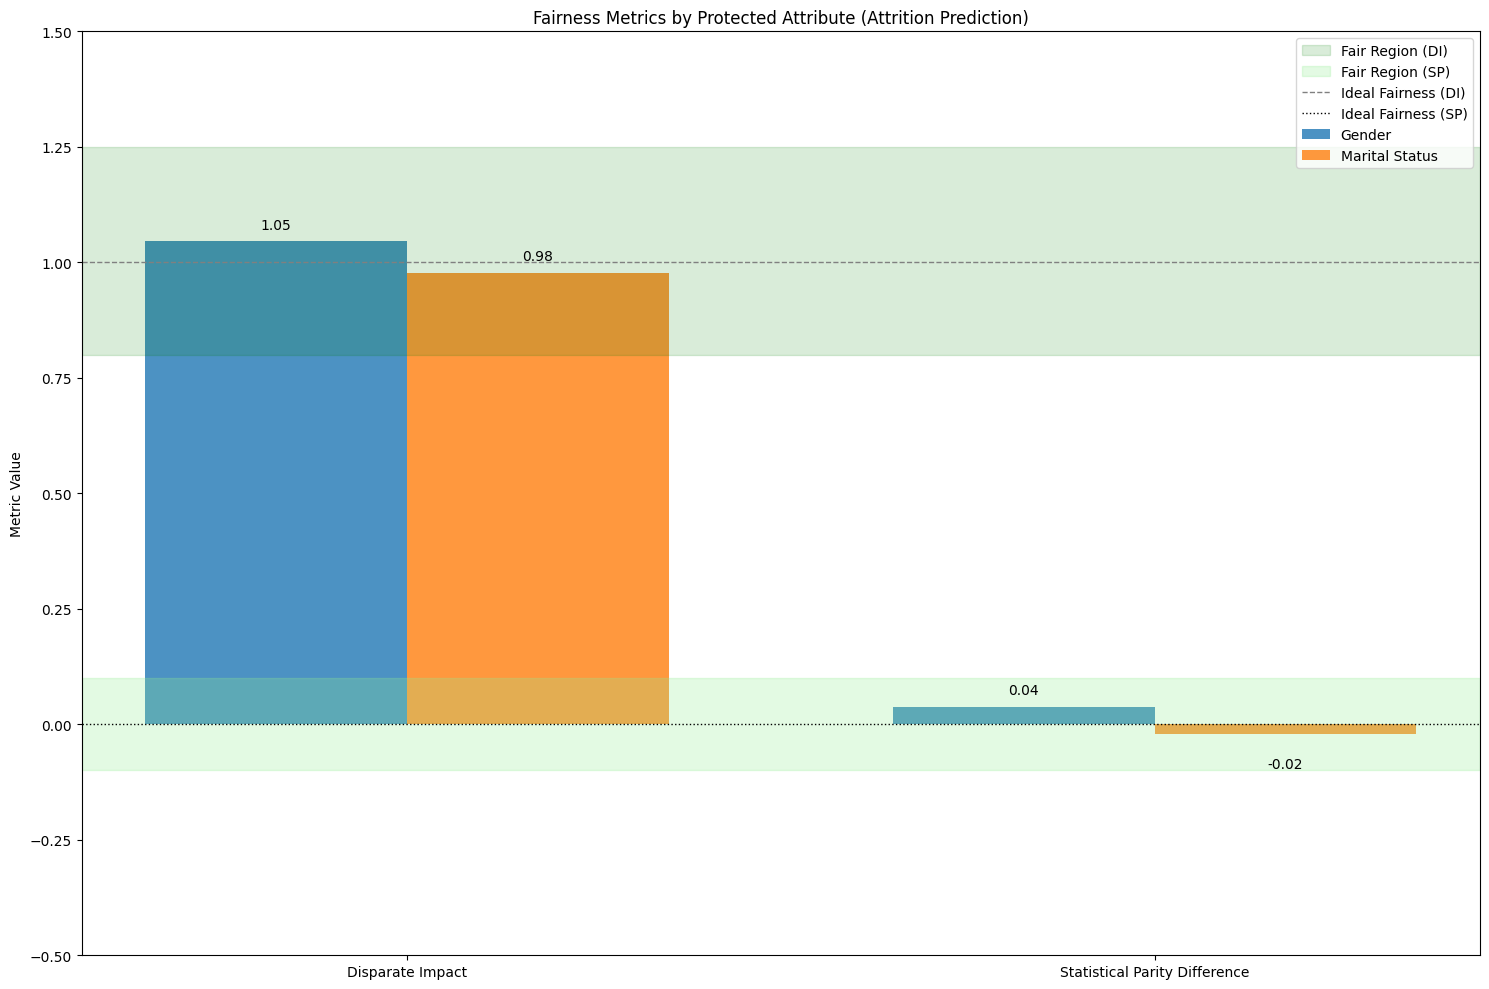

In [50]:
print("Step 5: Graphing step 4.5")
trans_di = [di_gender_attr_w, di_maritalStatus_attr_w]
trans_spd = [spd_gender_attr_w, spd_maritalStatus_attr_w]

# Metric labels
metrics = ['Disparate Impact', 'Statistical Parity Difference']
groups = ['Gender', 'Marital Status']

# Prepare bar positions
x = np.arange(len(metrics))  # positions for 'Disparate Impact', 'Mean Difference'
width = 0.35                 # width of each bar

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the bars
bars1 = ax.bar(x - width/2, [trans_di[0], trans_spd[0]],
               width, label='Gender', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, [trans_di[1], trans_spd[1]],
               width, label='Marital Status', color='#ff7f0e', alpha=0.8)

# Fairness regions
# Disparate Impact fair region (only applies to first metric)
ax.axhspan(0.8, 1.25, color='green', alpha=0.15, label='Fair Region (DI)')
# Statistical Parity Difference fair region (second metric)
ax.axhspan(-0.1, 0.1, color='lightgreen', alpha=0.25, label='Fair Region (SP)')

# Reference lines
ax.axhline(1, color='gray', linestyle='--', linewidth=1, label='Ideal Fairness (DI)')
ax.axhline(0, color='black', linestyle=':', linewidth=1, label='Ideal Fairness (SP)')

# Axis and title
ax.set_ylabel('Metric Value')
ax.set_title('Fairness Metrics by Protected Attribute (Attrition Prediction)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(-0.5, 1.5)
ax.legend(loc='upper right')

# Annotate bar values
for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_height() + (0.02 if bar.get_height() >= 0 else -0.05),
                f'{bar.get_height():.2f}', ha='center', va='bottom' if bar.get_height() >= 0 else 'top')

plt.tight_layout()
plt.savefig('4_5_fairness_metric_charts.png')
plt.show()
plt.close()

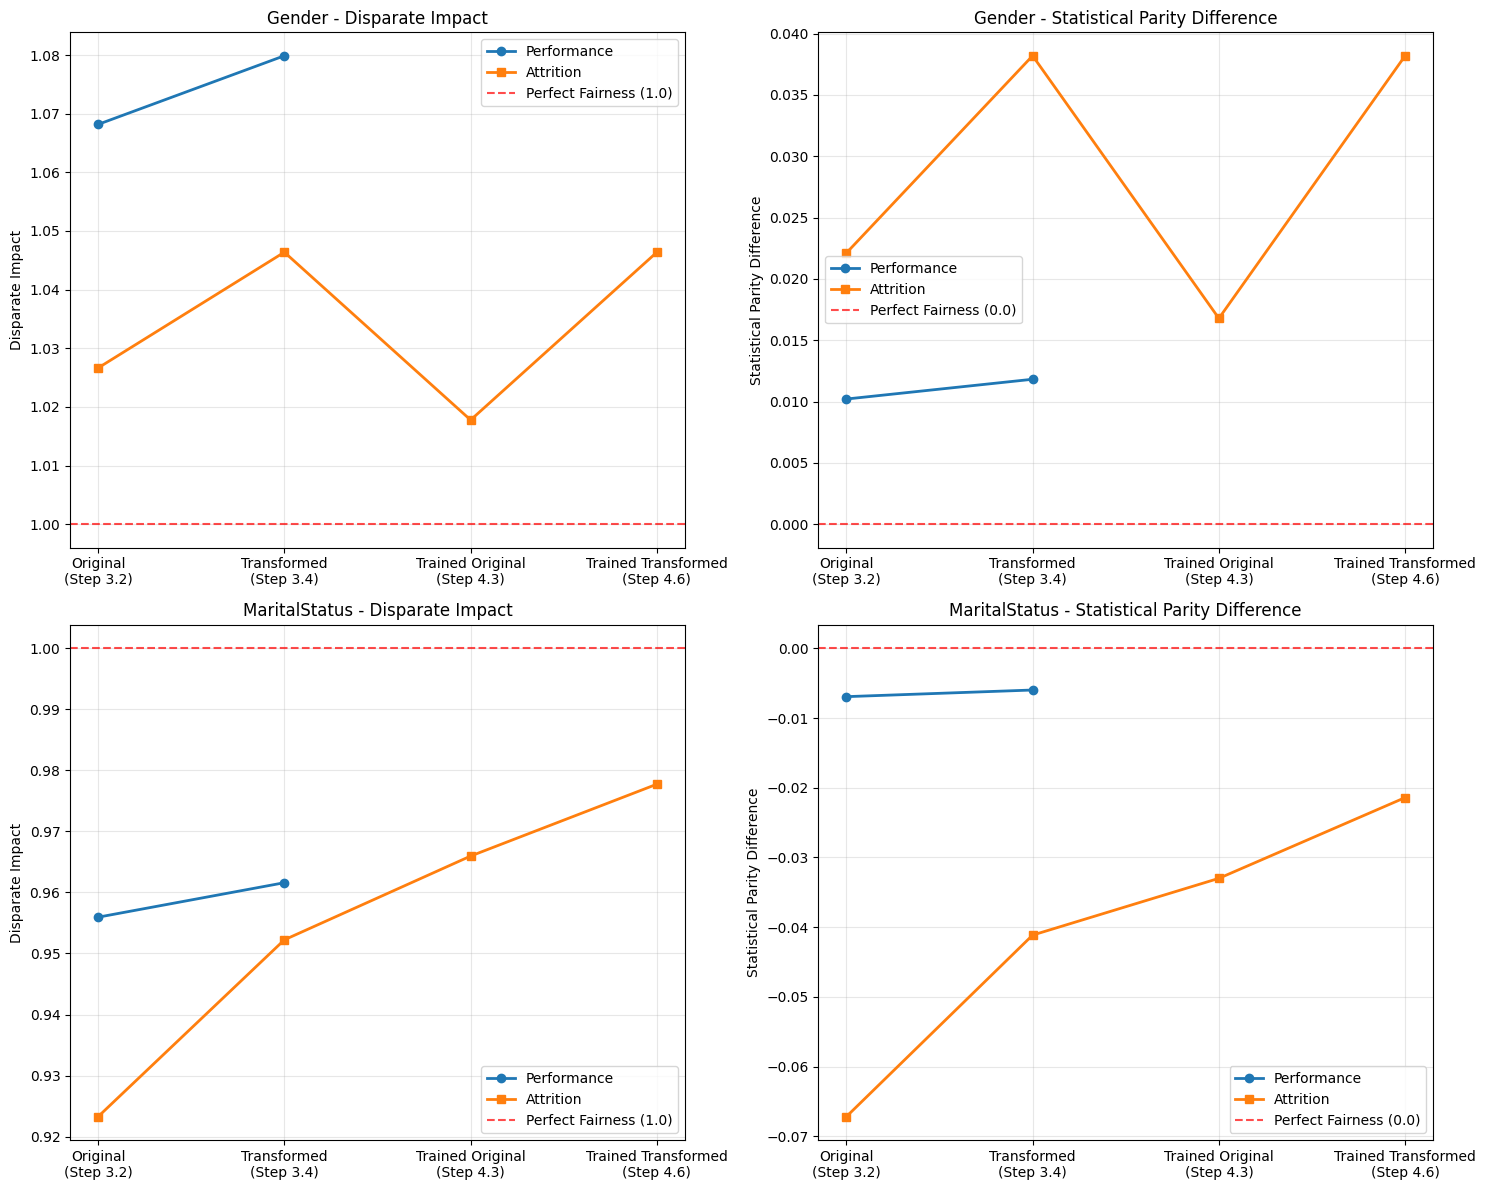

In [ ]:
# Step 5: Analysis - Complete Fairness Metrics Comparison
# ========================================================

# Data from Step 3 (Mark) and Step 4 (Mike)
data = {
    'Step 3.2 - Original Dataset': {
        'Gender_Attrition_DI': 1.026639,
        'Gender_Attrition_SPD': 0.022109,
        'Gender_Performance_DI': 1.068182,
        'Gender_Performance_SPD': 0.010204,
        'MaritalStatus_Attrition_DI': 0.923267,
        'MaritalStatus_Attrition_SPD': -0.067156,
        'MaritalStatus_Performance_DI': 0.955943,
        'MaritalStatus_Performance_SPD': -0.006939
    },
    'Step 3.4 - Transformed Dataset': {
        'Gender_Attrition_DI': 1.046385,
        'Gender_Attrition_SPD': 0.038197,
        'Gender_Performance_DI': 1.079889,
        'Gender_Performance_SPD': 0.011816,
        'MaritalStatus_Attrition_DI': 0.952235,
        'MaritalStatus_Attrition_SPD': -0.041128,
        'MaritalStatus_Performance_DI': 0.961593,
        'MaritalStatus_Performance_SPD': -0.005987
    },
    'Step 4.3 - Trained on Original': {
        'Gender_Attrition_DI': 1.017763,
        'Gender_Attrition_SPD': 0.016783,
        'MaritalStatus_Attrition_DI': 0.965959,
        'MaritalStatus_Attrition_SPD': -0.032989
    },
    'Step 4.6 - Trained on Transformed': {
        'Gender_Attrition_DI': 1.046385,
        'Gender_Attrition_SPD': 0.038197,
        'MaritalStatus_Attrition_DI': 0.977732,
        'MaritalStatus_Attrition_SPD': -0.021408
    }
}

# Create comprehensive comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Gender - Disparate Impact
stages = ['Original\n(Step 3.2)', 'Transformed\n(Step 3.4)', 'Trained Original\n(Step 4.3)', 'Trained Transformed\n(Step 4.6)']
gender_di_attrition = [1.026639, 1.046385, 1.017763, 1.046385]
gender_di_performance = [1.068182, 1.079889, None, None]  # Step 4 only did Attrition

ax1.plot(stages[:2], gender_di_performance[:2], 'o-', label='Performance', linewidth=2)
ax1.plot(stages, gender_di_attrition, 's-', label='Attrition', linewidth=2)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Fairness (1.0)')
ax1.set_title('Gender - Disparate Impact')
ax1.set_ylabel('Disparate Impact')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Gender - Statistical Parity Difference  
gender_spd_attrition = [0.022109, 0.038197, 0.016783, 0.038197]
gender_spd_performance = [0.010204, 0.011816, None, None]

ax2.plot(stages[:2], gender_spd_performance[:2], 'o-', label='Performance', linewidth=2)
ax2.plot(stages, gender_spd_attrition, 's-', label='Attrition', linewidth=2)
ax2.axhline(y=0.0, color='red', linestyle='--', alpha=0.7, label='Perfect Fairness (0.0)')
ax2.set_title('Gender - Statistical Parity Difference')
ax2.set_ylabel('Statistical Parity Difference')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MaritalStatus - Disparate Impact
marital_di_attrition = [0.923267, 0.952235, 0.965959, 0.977732]
marital_di_performance = [0.955943, 0.961593, None, None]

ax3.plot(stages[:2], marital_di_performance[:2], 'o-', label='Performance', linewidth=2)
ax3.plot(stages, marital_di_attrition, 's-', label='Attrition', linewidth=2)
ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Fairness (1.0)')
ax3.set_title('MaritalStatus - Disparate Impact')
ax3.set_ylabel('Disparate Impact')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. MaritalStatus - Statistical Parity Difference
marital_spd_attrition = [-0.067156, -0.041128, -0.032989, -0.021408]
marital_spd_performance = [-0.006939, -0.005987, None, None]

ax4.plot(stages[:2], marital_spd_performance[:2], 'o-', label='Performance', linewidth=2)
ax4.plot(stages, marital_spd_attrition, 's-', label='Attrition', linewidth=2)
ax4.axhline(y=0.0, color='red', linestyle='--', alpha=0.7, label='Perfect Fairness (0.0)')
ax4.set_title('MaritalStatus - Statistical Parity Difference')
ax4.set_ylabel('Statistical Parity Difference')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('5_2_Comprehensive_Fairness_Comparison.png')
plt.show()